## Imports

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy import sparse
from surprise import Dataset, Reader, SVD
from collections import Counter

In [3]:
df = pd.read_csv("training_data/data.csv")
df.head()

,user_id,song_id,listen_count,timestamp,interaction
0,66,133,3,2024-10-13 14:06:06.191414,2
1,10,286,1,2024-04-11 19:22:06.191437,0
2,79,201,1,2025-01-11 04:56:06.191443,0
3,24,255,1,2024-03-23 00:11:06.191447,0
4,62,146,1,2024-01-28 09:23:06.191451,2


## Data Analysis

### User Behaviour Analysis

Average number of listens per user: 44.71
Most active users: [26, 95, 25, 12, 62, 58, 28, 37, 4, 36] and Most Inactive Users: [22, 57, 8, 43, 30, 42, 6, 44, 29, 74]


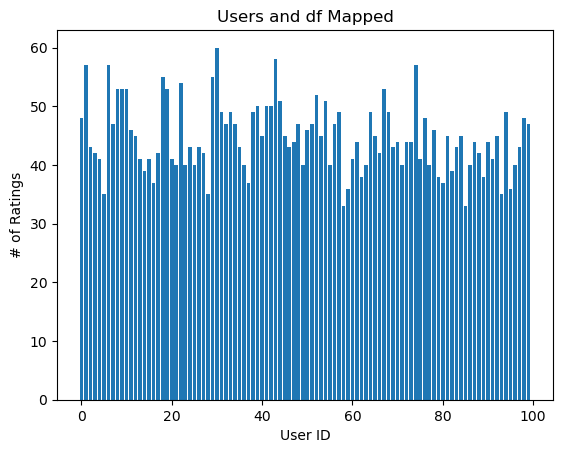

In [6]:
# users = Counter(sorted(df["user_id"]))
users = df["user_id"].value_counts()

# plot user df
plt.title("Users and df Mapped")
plt.bar(users.index,users.values)
plt.xlabel("User ID")
plt.ylabel("# of Ratings")

# average listens per user
average_ratings_per_user = users.mean()
print("Average number of listens per user:",average_ratings_per_user)

# top 10 active/inactive users
listen_count_users = df.groupby("user_id")["listen_count"].sum()
sorted_users = listen_count_users.sort_values(ascending=True)
top_active_users = list(sorted_users.index[:10])
top_inactive_users = list(sorted_users.index[-10:])
print(f'Most active users: {top_active_users} and Most Inactive Users: {top_inactive_users}')


### Song Analysis

Number of unique songs: 377
Number of unlistened songs: 3
Most played songs: [45, 499, 94, 132, 444] and Least played songs: [425, 462, 461, 480, 1]


Text(0, 0.5, 'Number of Listens')

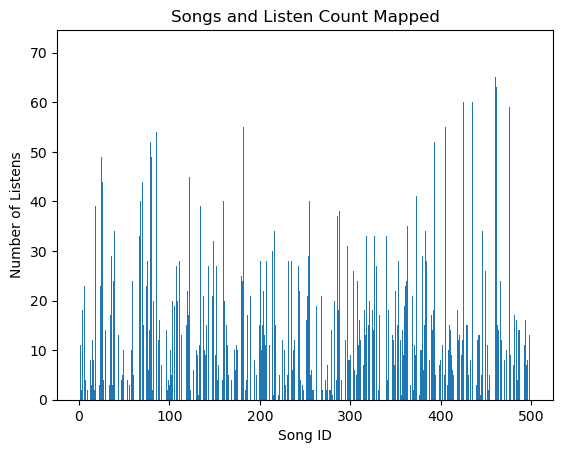

In [8]:
songs = df["song_id"]

# number of songs
unique_songs = songs.nunique()
print(f'Number of unique songs: {unique_songs}')

# check for unrated songs
all_songs = songs.unique()
listen_count = df.groupby("song_id")["listen_count"].sum()
listen_count = listen_count.reindex(all_songs, fill_value=0)
unplayed = (listen_count == 0).sum()
print(f'Number of unlistened songs: {unplayed}')

#top 5 most/least played songs
sorted_listen_count = listen_count.sort_values(ascending=True)
top_played_songs = list(sorted_listen_count.index[:5])
least_played_songs = list(sorted_listen_count.index[-5:])
print(f'Most played songs: {top_played_songs} and Least played songs: {least_played_songs}')


# plot listen counts
plt.title("Songs and Listen Count Mapped")
plt.bar(listen_count.index, listen_count.values)
plt.xlabel("Song ID")
plt.ylabel("Number of Listens")


### Rating Patterns

Text(0, 0.5, 'Frequency')

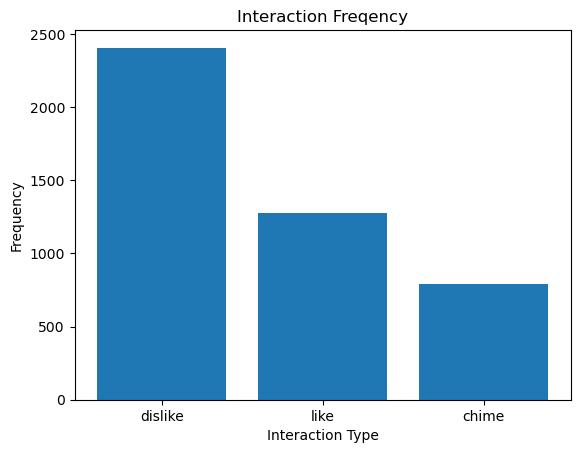

In [10]:
# ratings chart
ratings = df["interaction"].value_counts()
interaction_type = ["dislike","like","chime"]
plt.title("Interaction Freqency")
plt.bar(interaction_type, ratings.values)
plt.xlabel("Interaction Type")
plt.ylabel("Frequency")

### Matrix Sparsity

In [27]:
user_item_matrix = df.pivot(
    index='user_id',
    columns='song_id',
    values='interaction'
)

# handling empty values
user_item_matrix = user_item_matrix.fillna(0)
sparsity = 1.0 - np.count_nonzero(user_item_matrix) / user_item_matrix.size
print(f"Matrix sparsity: {sparsity:.2%}")


Matrix sparsity: 94.52%


## Data Preprocessing

In [35]:
from scipy.sparse import csr_matrix
# compressed sparse row

sparse_matrix = csr_matrix(user_item_matrix.values)
sparse_matrix.shape

# 3 methods to explore: time-based splitting, leave-one-out, random splitting with user stratification

(100, 377)

### Time-based splitting

In [38]:
df_sorted  = df.sort_values("timestamp")

# determine split point (we'll be doing 80/20 split testing)
split_idx = int(len(df_sorted)*0.8)

df_train = df_sorted.iloc[:split_idx] #training set
df_test = df_sorted.iloc[split_idx:] #testing set

#training matrix
train_matrix = df_train.pivot(
    index="user_id",
    columns="song_id",
    values="interaction"
).fillna(0)
train_sparse = csr_matrix(train_matrix.values)

#testing matrix
test_matrix = df_test.pivot(
    index="user_id",
    columns="song_id",
    values="interaction"
).fillna(0)

test_sparse = csr_matrix(test_matrix.values)

print(train_sparse)

  (0, 13)	2.0
  (0, 30)	1.0
  (0, 37)	2.0
  (0, 46)	1.0
  (0, 47)	1.0
  (0, 57)	1.0
  (0, 58)	2.0
  (0, 60)	1.0
  (0, 69)	1.0
  (0, 95)	1.0
  (0, 115)	1.0
  (0, 123)	2.0
  (0, 126)	1.0
  (0, 132)	1.0
  (0, 138)	1.0
  (0, 142)	1.0
  (0, 153)	2.0
  (0, 164)	1.0
  (0, 165)	1.0
  (0, 167)	1.0
  (0, 172)	1.0
  (0, 173)	1.0
  (0, 200)	2.0
  (0, 215)	1.0
  (0, 217)	2.0
  :	:
  (98, 55)	1.0
  (98, 78)	2.0
  (98, 103)	1.0
  (98, 104)	2.0
  (98, 181)	1.0
  (98, 200)	1.0
  (98, 221)	1.0
  (98, 232)	1.0
  (98, 262)	1.0
  (98, 285)	1.0
  (98, 340)	1.0
  (99, 24)	2.0
  (99, 29)	1.0
  (99, 46)	2.0
  (99, 78)	1.0
  (99, 107)	2.0
  (99, 125)	1.0
  (99, 187)	1.0
  (99, 208)	1.0
  (99, 211)	1.0
  (99, 217)	1.0
  (99, 272)	1.0
  (99, 303)	1.0
  (99, 314)	1.0
  (99, 360)	2.0
